In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from corner import corner
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
plt.style.use('seaborn-poster')

In [4]:
from setup_files.mocks_paper1.mock_models import models, run_names

In [6]:
res = {}
for k in models.keys():
    res[k] = ppy.results.ResultsPlotter('results/paper1_{:s}.csv'.format(k), live_file='results/paper1_{:s}_live.csv'.format(k),
                                        true_model=models[k], run_name=run_names[k])

/Users/bcook/pCMDs/pixcmd/pcmdpy/pcmdpy/sampling/results.py:199: RuntimeWarning: invalid value encountered in sqrt
  logzerrs.append(np.sqrt(logzvar))


# Dynesty Weights

We need to figure out how to handle the Dynesty weighting.

When a run is completed (or it ends early, and we keep the live points), we find that the last handful of points (often only 1 point) have nearly all the weight.

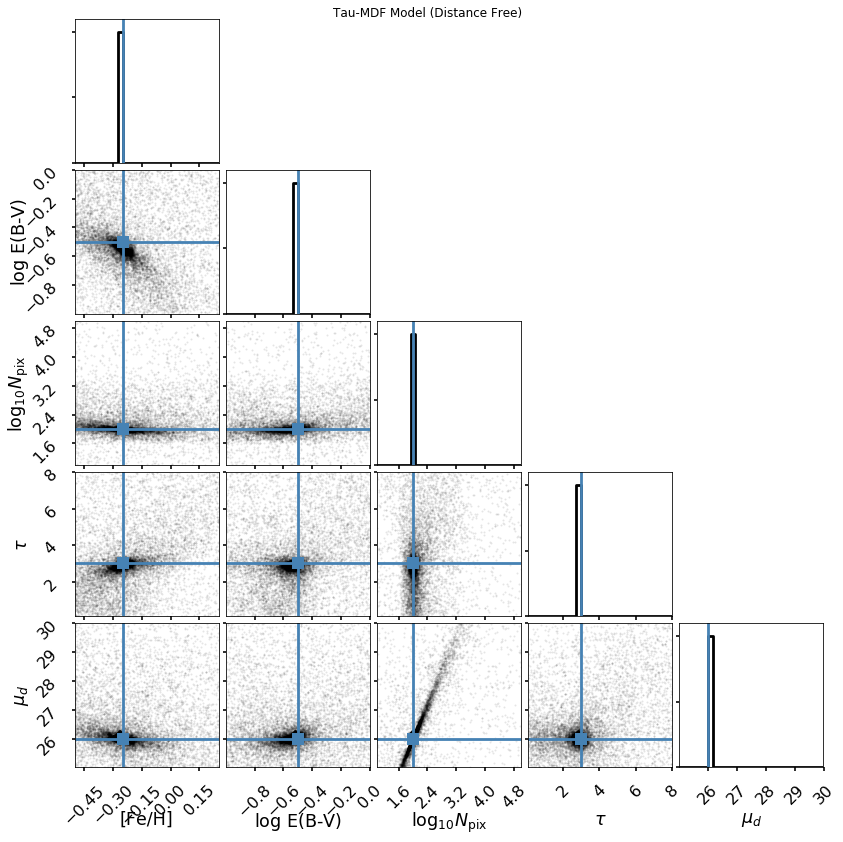

In [27]:
res['mock_5'].plot_corner(weight=True);

In [31]:
res['mock_5'].weights

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.89201164e-09, 1.07720536e-07, 9.99999890e-01])

Text(0.5,1,'Mock 5')

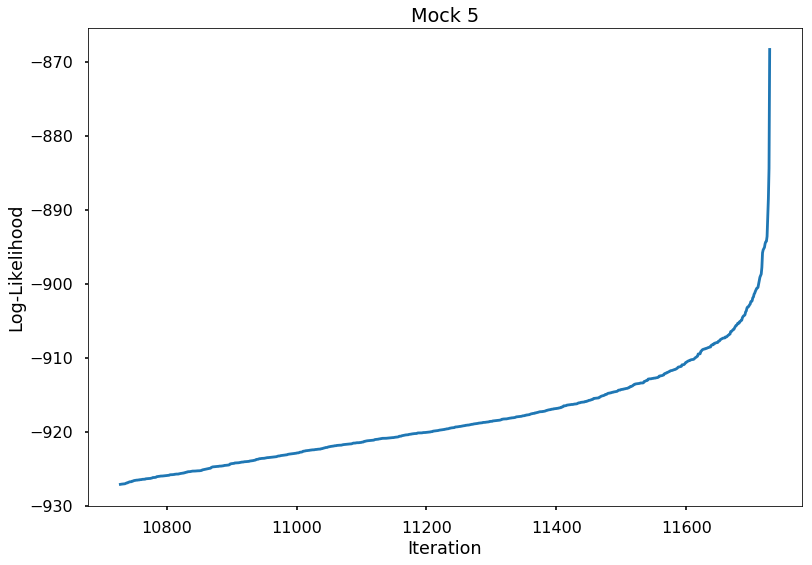

In [40]:
plt.plot(res['mock_5'].df.logl[-1000:])
plt.ylabel('Log-Likelihood')
plt.xlabel('Iteration')
plt.title('Mock 5')

Nearly every mock run exhibits the same behavior by the time it completes

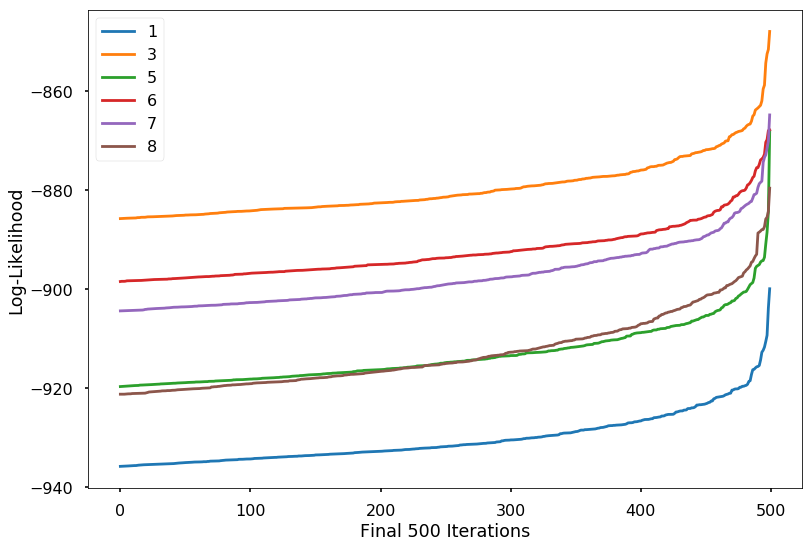

In [66]:
for i in [1, 3, 5, 6, 7, 8]:
    k = f'mock_{i}'
    r = res[k]
    y = np.array(r.df.logl[-500:].values)
    plt.plot(y, label=i)
plt.ylabel('Log-Likelihood')
plt.xlabel('Final 500 Iterations')
plt.legend(loc=0)

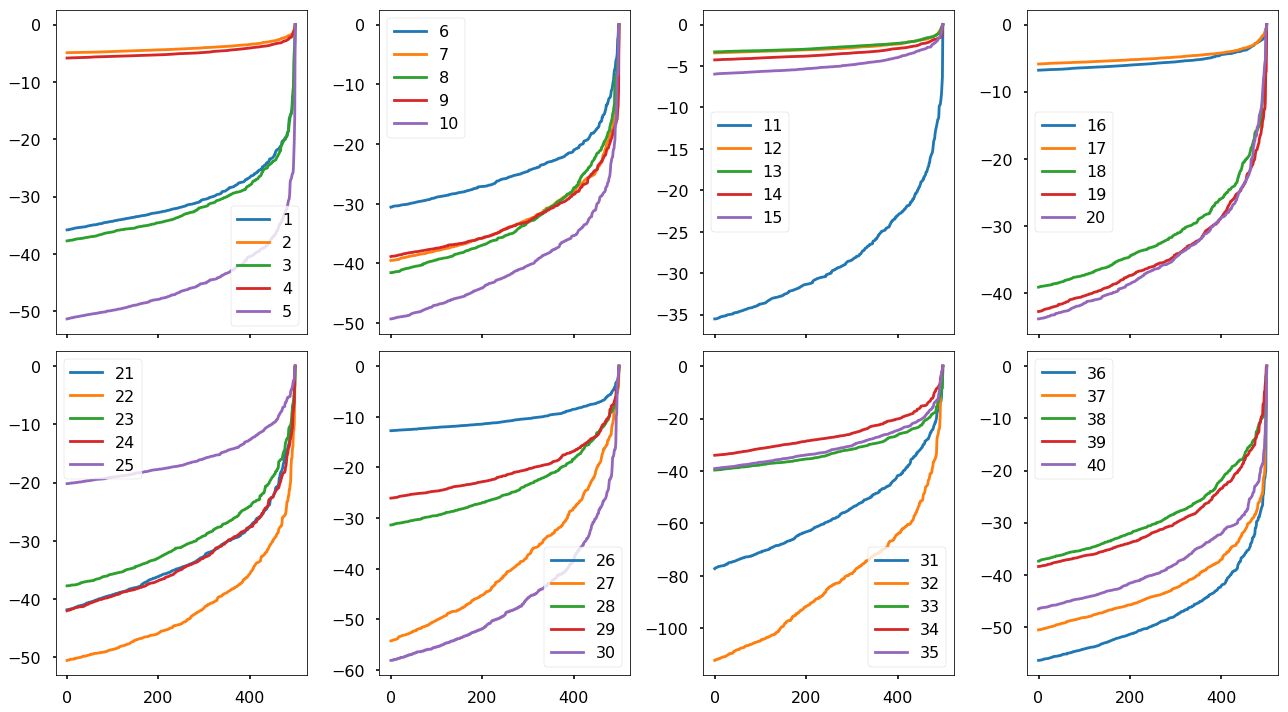

In [67]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 10), sharex=True)
axes = axes.flatten()
for i in range(1, 41):
    a = axes[(i-1)//5]
    k = f'mock_{i}'
    r = res[k]
    y = np.array(r.df.logl[-500:].values)
    y -= y.max()
    a.plot(y, label=i)
    a.legend(loc=0)
plt.tight_layout()

Our hypothesis is that this is due to the Stochastic nature of the likelihood calls... The final $\sim 100$ Dynesty points are rare, positive fluctuations in Likelihood space, and so we shouldn't trust their values fully.

We could potentially trim the final $N$ Dynesty points. Let's look at how that would affect our parameter estimates:

Text(0.5,0,'Final Points Trimmed')

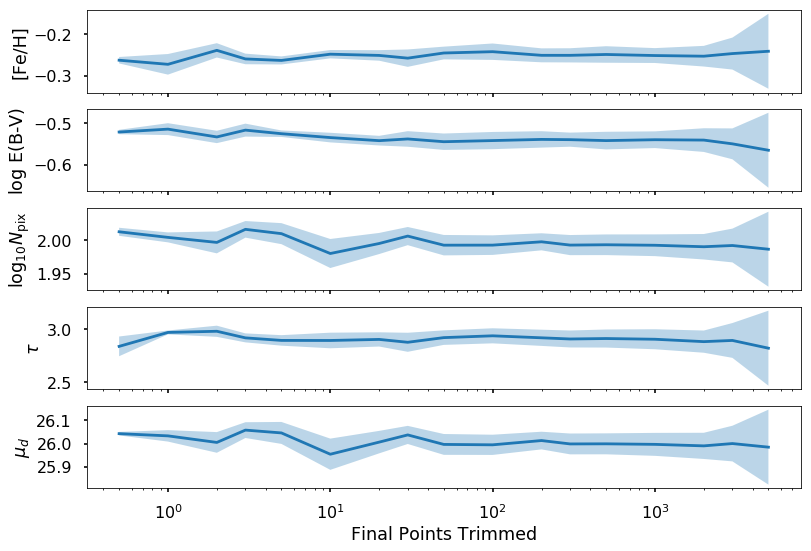

In [59]:
trims = [0, 1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000]
means = np.array([res['mock_5'].means(trim=t) for t in trims]).T
stds = np.array([res['mock_5'].stds(trim=t) for t in trims]).T

trims[0] = 0.5
fig, axes = plt.subplots(nrows=5, sharex=True)
for i, a in enumerate(axes):
    a.plot(trims, means[i])
    a.fill_between(trims, y1=means[i]-stds[i], y2=means[i]+stds[i], alpha=0.3)
    a.set_ylabel(res['mock_5'].labels[i])
    a.set_xscale('log')
axes[-1].set_xlabel('Final Points Trimmed')

The errors on the parameters appears to be underestimated until we trim the first dozen or so points.

So, we propose one of two approaches for handling the results of the Dynesty runs

First, identify a criterion to determine when the Log-Likelihoods are untrustworthy

Then, either:

* Remove all Dynesty points past that point (ex: the final $\sim 200$ points)

* Or, downweight their weights, perhaps as if they had constant $\mathcal{L}$


# Confirm Likelihood Bias

Let's confirm our suspicions by re-sampling the Likelihoods

In [69]:
ppy.GPU_ACTIVE

False

In [68]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f, mag_system='ab')

In [71]:
if not ppy.GPU_ACTIVE:
    import pcmdpy_gpu as ppy
assert ppy.GPU_ACTIVE
driv = ppy.driver.driver(iso_model, gpu=True)

AssertionError: Requested GPU acceleration unavailable, for reason:
   pycuda not installed.
Please ensure you are using a machine with an NVidia GPU and CUDA installed, then install pycuda
(such as via  "pip install pycuda")

In [76]:
gal = models['mock_5']